<a href="https://colab.research.google.com/github/Shilaho/consumer-purchase-behavior-prediction/blob/main/Copy_of_Predicting_Consumer_Behavior.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
import datetime as dt 
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rcParams
from IPython.display import Image
from IPython.core.display import HTML 
from itertools import product
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle
from IPython.core.display import HTML 
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import warnings 
warnings.filterwarnings('ignore')

# Introduction

The goal of this project is to develop a predictive model based on the order and online customer behavior data to forecast product category (prodcat1) a customer is likely to order.  The data was obtained from Shutterfly Inc.  (source: https://github.com/sflydatascience/homework1/blob/master/data.zip). The data includes two time-series datasets, one is Non-Transactional Data (Online data), another is Transactional Data (Order Data). 

To make the customer purchase prediction model, this project included the following sections :
1.	Exploration and Understanding of the Data Sets<br/>
    1.1	Product Analysis<br/>
        1.1.1	Popularity of prodast1 in terms of the number of orders.<br/>
        1.1.2	Popularity of prodast1 in terms of the number of browsing sessions.<br/>
        1.1.3	The revenue of each type of prodcast1<br/>
    1.2	Customer Behavior<br/>
        1.2.1	Which channel is more popular in terms of event1 and event2<br/>
        1.2.2	Customer Purchase RFM (Recency, Frequency, Monetary value)  Analysis  <br/>
        1.2.3	Customer Segment with RMF <br/>
2.	Model Design and Sampling <br/>
    2.1	Training/ Testing Data Split <br/>
    2.2	 Label Generation <br/>
3.	Feature engineering & Selection <br/>
    3.1	Non-Transaction Data Features <br/>
        3.1.1	How the customer interacts with your website (online event1 and online event2 )<br/>
        3.1.2	How many times a customer browsing an item (No. of sessions) <br/>
    3.2	Transaction Data Features<br/>
        3.2.1	Total Number of orders <br/>
        3.2.2	Order Recency <br/>
        3.2.3	Order Frequency of each category of procat1 <br/>
        3.2.4	Total order revenue<br/>
    3.3	Feature Correlation Matrix <br/>
4.	Model Generation  <br/>
    4.1	Grid Search to find the best parameters <br/>
    4.2	Random Forest Classification Model<br/>
    4.3	 Feature Importance Analysis <br/>
    4.4	Prediction Analysis <br/>
5.	Model Evaluation <br/>
    5.1	Confusion Matrix <br/>
    5.2	 AUC<br/>
6.	Summary & Discussion <br/>


# 1. Exploration and Understanding of the Data Sets

In [ ]:
online = pd.read_csv('online.csv') # Load the Non-transicational dataset
order = pd.read_csv('order.csv') # Load the Transicational dataset
print(online.info()) # print the info of the Non-transicational dataset
print(order.info()) # print the info of the Transicational dataset

order.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954774 entries, 0 to 954773
Data columns (total 7 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   session   954774 non-null  int64  
 1   visitor   954774 non-null  int64  
 2   dt        954774 non-null  object 
 3   custno    954774 non-null  int64  
 4   category  954774 non-null  int64  
 5   event1    164928 non-null  float64
 6   event2    954774 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 51.0+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263278 entries, 0 to 263277
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   custno     263278 non-null  int64  
 1   ordno      263278 non-null  int64  
 2   orderdate  263278 non-null  object 
 3   prodcat2   261455 non-null  float64
 4   prodcat1   263278 non-null  int64  
 5   revenue    263278 non-null  float64
dtypes: float64(2), int6

,custno,ordno,orderdate,prodcat2,prodcat1,revenue
0,18944,64694,2016-11-27 20:57:20,NaN,1,53.30
1,18944,114405,2017-04-29 20:18:04,NaN,1,0.10
2,18944,28906,2017-04-23 21:31:03,NaN,1,141.66
3,36096,62681,2016-02-25 07:16:33,NaN,1,36.82
4,1,1,2017-06-12 08:27:59,NaN,1,8.35


In [ ]:
print(f' The most recent time of online session : {online.dt.max()}')  
print (f' The start time of online session : {online.dt.min()}') 
print(f' The most recent time of online order : {order.orderdate.max()}')
print(f' The start time of online order : {order.orderdate.min()}') 

 The most recent time of online session : 2017-12-31 23:58:05
 The start time of online session : 2016-01-01 00:00:08
 The most recent time of online order : 2019-01-02 23:54:58
 The start time of online order : 2016-01-01 05:05:14


### Dataset Descriptions
The data includes two time-series datasets, one is Non-Transactional Data (Online data), another is Transactional Data (Order Data). The Non-Transactional Data (Online data) starts from 2016-01-01 to 2017-12-31, while the Transaction Data starts from 2016-01-01 to 2019-01-02. Therefore, I will only use the data range from 2016-01-01 to 2017-12-31 for both datasets. 

### Data Prepreprocessing 

- Convert the data type of dt and orderdate to datetime 
- Truncate order data only between 2016-01-01 to 2017-12-31 

In [ ]:
# Convert the data type of dt and orderdate 
order['orderdate']= pd.to_datetime(order['orderdate']) 
online['dt'] = pd.to_datetime(online['dt']) 
# Truncate order data only between 2016-01-01 to 2017-12-31
order = order [order['orderdate'] < '2018-01-01']

## 1.1 Product Analysis

### 1.1.1. Popularity of prodast1 in terms of the number of orders.

Text(-8.700000000000003, 0.5, 'Count')

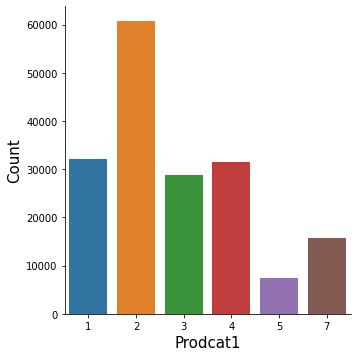

In [ ]:
ax = sns.catplot(x="prodcat1", kind="count",height=5, data = order)
for ax in ax.axes.flat: 
    plt.setp(ax.get_xticklabels(), fontsize= 10)
plt.xlabel('Prodcat1', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

The poplarity is not evenly distributed acrross the categories. The most popular category is 2 in Procat1 and the least popular category is 5 in Procat1 in terms of number of orders.

### 1.1.2. Popularity of prodast1 in terms of the number of browsing sessions

Text(-14.950000000000003, 0.5, 'Count')

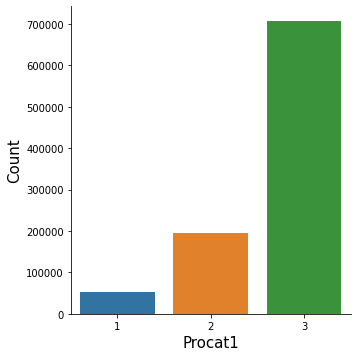

In [ ]:
ax = sns.catplot(x="category", kind="count",height=5, data = online)
for ax in ax.axes.flat: 
    plt.setp(ax.get_xticklabels(), fontsize= 10)
plt.xlabel('Procat1', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

There are only 3 categories in online browsing category (procat1), while proact1 has a total of 6 classes, therefore the online data is incomplete. Among these three categories, the category 3 is the most popular in terms of the number of browsing sessions.

###  1.1.3. Check the Revenue of each category in prodcat1

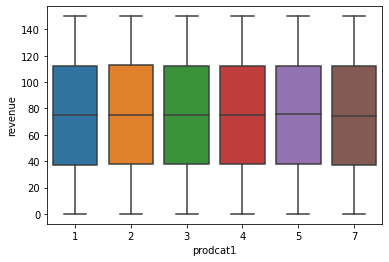

In [ ]:
ax = sns.boxplot(x = "prodcat1", y = 'revenue', data = order)

The revenue is evenly distributed across all categories in procat1. The mean value of all classes is around 75. 

## 1.2 Customer Behavior 

### 1.2.1 Which channel is more popular in terms of event1 and event2?

Text(0.5, 1.0, 'Number of sessions per category of event1')

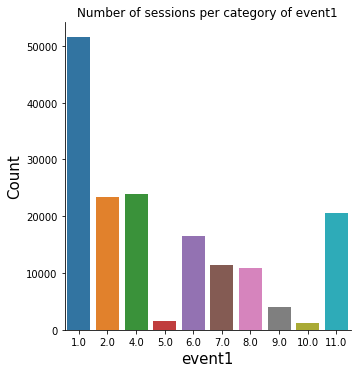

In [ ]:
ax = sns.catplot(x="event1", kind="count",height=5, data = online)
for ax in ax.axes.flat: 
    plt.setp(ax.get_xticklabels(), fontsize= 10)
plt.xlabel('event1', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Number of sessions per category of event1')

Text(0.5, 1.0, 'Number of sessions per category of event2')

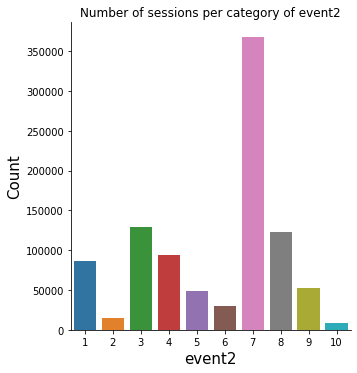

In [ ]:
ax = sns.catplot(x="event2", kind="count",height=5, data = online)
for ax in ax.axes.flat: 
    plt.setp(ax.get_xticklabels(), fontsize= 10)
plt.xlabel('event2', fontsize = 15)
plt.ylabel('Count', fontsize = 15)
plt.title('Number of sessions per category of event2')

The traffic is not evenly distributed in both events. In event1, class 1 attracts more traffic. In event 2, class 7 attracts more traffic. The channel may affect the purchasing behavior.

## 1.2.2	Customer Purchase RFM (Recency, Frequency, Monetary value)  Analysis  

RMF stands for Recency, Frequency and Monetary value and the RMF metrics are calculated for each customer.  
- Regency: Who have purchased recently? The number of days since last purchased. 
- Frequency: who has purchased frequently? It means the total number of purchases. 
- Monetary Value: who have high purchase amount? It means the total money customer spend.
<br> 

The following steps are used to run the RMF Analysis : 
- Calculate the RMF metrics for each customer.
- Add segment numbers to RMF table based on the quantile values.
- Sort according to the RMF scores from the best customers.
- Label the customer for different segments based on their RFM scores.

In [ ]:
# Get the max purchase date for each customer
user_segment = order.groupby('custno').orderdate.max().reset_index()
# Calculate the number of inactive numbers of each customer 
user_segment['Recency'] = (user_segment['orderdate'].max() - user_segment['orderdate']).dt.days
# Calculate the Frequency and revenue for each customer 
rfmTable = order.groupby('custno').agg({'ordno': lambda x: len(x), 
                                        'revenue': lambda x: x.sum()}).reset_index().rename(
                                        columns={"ordno": "Frequency", "revenue": "Revenue"})
rfmTable = pd.merge(rfmTable, user_segment, on = 'custno').drop(['orderdate'], axis = 1)

# Functions for RMF score 
def RScore(x,p,d):
    """ Generate the Regency Score based on the quantile values"""
    if x<=d[p][0.25] :
        return 1 
    elif x<=d[p][0.5]:
        return 2 
    elif x<=d[p][0.75]:
        return 3 
    else :
        return 4 
def FMScore(x,p,d):
    """ Generate the Frequency and Monetary Score based on the quantile values """
    if x<=d[p][0.25] :
        return 4 
    elif x<=d[p][0.5]:
        return 4 
    elif x<=d[p][0.75]:
        return 2 
    else :
        return 1 
    
# Add segment numbers to RMF table based on the quantile values.
quantiles = rfmTable.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
rfmTable['r_quartile'] = rfmTable['Recency'].apply(RScore, args=('Recency',quantiles,))
rfmTable['f_quartile'] = rfmTable['Frequency'].apply(FMScore, args=('Frequency',quantiles,))
rfmTable['m_quartile'] = rfmTable['Revenue'].apply(FMScore, args=('Revenue',quantiles,))
# Calculate the RFM score of each customer 
rfmTable['RFMScore'] = rfmTable.r_quartile.map(str) + \
                           rfmTable.f_quartile.map(str) +\
                           rfmTable.m_quartile.map(str)
# Sort according to the RMF scores from the best customers
rfmTable = rfmTable.sort_values(by = ['RFMScore'])

Text(0.5, 1.0, 'Distribution of Recency')

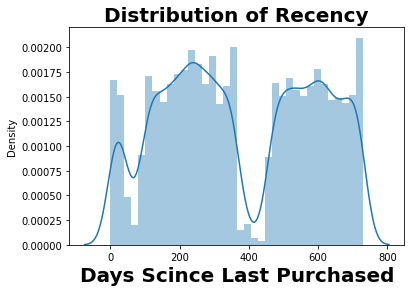

In [ ]:
ax = sns.distplot(rfmTable.Recency)
plt.xlabel('Days Scince Last Purchased', fontsize = 20, weight = 'bold')
plt.title('Distribution of Recency',
          fontsize = 20, weight = 'bold')

In [ ]:
rfmTable[['Frequency', 'Revenue', 'Recency']].describe()

,Frequency,Revenue,Recency
count,48819.000000,48819.000000,48819.000000
mean,3.610766,270.937096,376.625023
std,9.303500,701.181259,215.606670
min,1.000000,0.010000,0.000000
25%,1.000000,75.940000,196.000000
50%,2.000000,134.320000,341.000000
75%,3.000000,232.350000,576.000000
max,357.000000,24937.040000,730.000000


From the distribution of frequency, revenue and recency, we can infer that most of customers are inactive and purchase little. There are two peaks in the recency distribution data. 

## 1.2.3	Customer Segment with RMF 

Generally, the lowest recency, highest frequency and monetary amounts are our best customers. The following dataframe shows the details and markering strategies for each customer segement.

In [ ]:
rmf = {'Segement': ['Best Customers', 'Loyal Customers', 'Big Spenders',
                    'Almost Lost', 'Lost Customers', 'Lost Cheap Customer'],
      'RMF': [111, 'X1X', 'XX1', 311, 411, 444], 
      'Description':['Bought most recently and most often, and spend the most', 'Buy most frequently',
                    'spend the most', "Haven't puchased for some time, but purchased frequently and spend the most",
                     "Haven't puchased for long time, but purchased frequently and spend the most",
                     'Last purchased long ago, purchased few, and spend little'], 
      'Marketing':['No Price incentives, new products, and loyalty probrams', 'Use R and M to further segment', 
                  'Market your most expensive products', 'Aggressive price incentives', 'Aggressive price incentives',
                  "Don't spend too much trying to re-acquire"]}
pd.set_option('display.max_colwidth', -1)  
pd.DataFrame.from_dict(rmf)

,Segement,RMF,Description,Marketing
0,Best Customers,111,"Bought most recently and most often, and spend the most","No Price incentives, new products, and loyalty probrams"
1,Loyal Customers,X1X,Buy most frequently,Use R and M to further segment
2,Big Spenders,XX1,spend the most,Market your most expensive products
3,Almost Lost,311,"Haven't puchased for some time, but purchased frequently and spend the most",Aggressive price incentives
4,Lost Customers,411,"Haven't puchased for long time, but purchased frequently and spend the most",Aggressive price incentives
5,Lost Cheap Customer,444,"Last purchased long ago, purchased few, and spend little",Don't spend too much trying to re-acquire


Text(-2.4499999999999957, 0.5, 'Count')

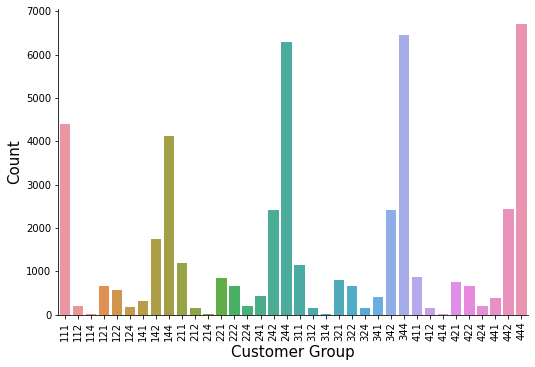

In [ ]:
ax = sns.catplot(x="RFMScore", kind="count", data = rfmTable, aspect=15/10)
for ax in ax.axes.flat: 
    plt.setp(ax.get_xticklabels(), fontsize= 10,  rotation='vertical')
plt.xlabel('Customer Group', fontsize = 15)
plt.ylabel('Count', fontsize = 15)

From the customer segmentation distribution, we can infer the following things
- Around 4500 best customers(111) out of  48819 customers. 
- Most of customers spend little (large number in group 144,244,344 and 444).
- Very few people buy frequently (less number in group x1X). 
<br> 

For a better visualization effect, I will only choose 3 customer segments (Best customers (111), Almost Lost (311) and Lost Cheap customers (444)) to see how they differ in the regency, revenue, and frequency.

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

plot_data = [
    go.Scatter(
        x=rfmTable.query("RFMScore == '111'")['Frequency'],
        y=rfmTable.query("RFMScore == '111'")['Revenue'],
        mode='markers',
        name='Best Customers',
        marker=dict(size=7,
                    line=dict(width=1),
                    color='blue',
                    opacity=0.8
                    )
    ),
    go.Scatter(
        x=rfmTable.query("RFMScore == '311'")['Frequency'],
        y=rfmTable.query("RFMScore == '311'")['Revenue'],
        mode='markers',
        name='Almost Lost Customers',
        marker=dict(size=9,
                    line=dict(width=1),
                    color='green',
                    opacity=0.5
                    )
    ),
    go.Scatter(
        x=rfmTable.query("RFMScore == '444'")['Frequency'],
        y=rfmTable.query("RFMScore == '444'")['Revenue'],
        mode='markers',
        name='Lost Cheap Customers',
        marker=dict(size=11,
                    line=dict(width=1),
                    color='red',
                    opacity=0.9
                    )
    ),
]

plot_layout = go.Layout(
    yaxis={'title': "Revenue"},
    xaxis={'title': "Frequency"},
    title='Segments'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot

plot_data = [
    go.Scatter(
        x=rfmTable.query("RFMScore == '111'")['Frequency'],
        y=rfmTable.query("RFMScore == '111'")['Recency'],
        mode='markers',
        name='Best Customers',
        marker=dict(size=7,
                    line=dict(width=1),
                    color='blue',
                    opacity=0.8
                    )
    ),
    go.Scatter(
        x=rfmTable.query("RFMScore == '311'")['Frequency'],
        y=rfmTable.query("RFMScore == '311'")['Recency'],
        mode='markers',
        name='Almost Lost Customers',
        marker=dict(size=9,
                    line=dict(width=1),
                    color='green',
                    opacity=0.5
                    )
    ),
    go.Scatter(
        x=rfmTable.query("RFMScore == '444'")['Frequency'],
        y=rfmTable.query("RFMScore == '444'")['Recency'],
        mode='markers',
        name='Lost Cheap Customers',
        marker=dict(size=11,
                    line=dict(width=1),
                    color='red',
                    opacity=0.9
                    )
    ),
]

plot_layout = go.Layout(
    yaxis={'title': "Recency"},
    xaxis={'title': "Frequency"},
    title='Segments'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)


In [ ]:
# Recency Revenue
plot_data = [
    go.Scatter(
        x=rfmTable.query("RFMScore == '111'")['Recency'],
        y=rfmTable.query("RFMScore == '111'")['Revenue'],
        mode='markers',
        name='Best Customers',
        marker=dict(size=7,
                    line=dict(width=1),
                    color='blue',
                    opacity=0.8
                    )
    ),
    go.Scatter(
        x=rfmTable.query("RFMScore == '311'")['Recency'],
        y=rfmTable.query("RFMScore == '311'")['Revenue'],
        mode='markers',
        name='Almost Lost Customers',
        marker=dict(size=9,
                    line=dict(width=1),
                    color='green',
                    opacity=0.5
                    )
    ),
    go.Scatter(
        x=rfmTable.query("RFMScore == '444'")['Recency'],
        y=rfmTable.query("RFMScore == '444'")['Revenue'],
        mode='markers',
        name='Lost Cheap Customers',
        marker=dict(size=11,
                    line=dict(width=1),
                    color='red',
                    opacity=0.9
                    )
    ),
]

plot_layout = go.Layout(
    yaxis={'title': "Revenue"},
    xaxis={'title': "Recency"},
    title='Segments'
)
fig = go.Figure(data=plot_data, layout=plot_layout)
py.iplot(fig)

Based on the visualization results, we can infer the following things: 
- Best customer recency between 0-200, while the almost lost customer is around 350-600 and lost cheap customer is around 550-800 days.
- There's a huge difference in recency, frequency, and revenue among three groups 
- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency

# 2. Model Design and Sampling 

## 2.1 Training/Tesing Data Split 

Since the datasets are time-related, it's inappriopriate to  split the training and testing set randomly. Therefore, I will create two time windows for spliting Traing/Testing set. Most of recency is around 1 year based on the eda result, I will use one year data for training features, later half year for labeling data.
- Training Features : 2016-01-01 to 2016-12-31 
- Training Labels : 2017-01-01 to 2017-06-30 
- Testing Features : 2016-06-30 to 2017-06-30 
- Testing Labels : 2017-07-01 to 2017-12-31

In [ ]:
## Convert 'orderdate' column to datetime data type
order['orderdate'] = pd.to_datetime(order['orderdate'])
online['dt'] = pd.to_datetime(online['dt'])

## Select the data for Training Features 
train_x_order = order[order.orderdate < '2017-01-01']
train_x_online = online[online.dt  < '2017-01-01']

## Select the data for Training Labels
train_y = order[(order['orderdate']>pd.to_datetime('2016-12-31')) & (order['orderdate']< pd.to_datetime('2017-07-01'))]

## Select the data for Testing Features 
test_x_order = order[(order['orderdate']>=pd.to_datetime('2016-06-30')) & (order['orderdate']< pd.to_datetime('2017-07-01'))]
test_x_online = online[(online['dt']>=pd.to_datetime('2016-06-30')) & (online['dt']< pd.to_datetime('2017-07-01'))]

## Select the data for Testing Labels
test_y = order[(order['orderdate']>=pd.to_datetime('2017-07-01')) & (order['orderdate']< pd.to_datetime('2018-01-01'))]


## 2.2 Label Generation 

Binary Labels for each category in procast1. 
<br>
1 : Purchased during the labeling time frame <br/>
0 : Not Purchased during the labeling time frame.

To generate the binary labels, I need to do the following steps.
- Table1 : Generate the new dataframe with the unique combination of custno and product1 
- Table2 : Count the purchasing count by grouping by the training_y data by custno and prodcut1 
- Join two tables using custno and prodcat1
- Convert the non-zero purchasing count to 1 and NA value to 1 in the joined table.

In [ ]:
# Training Labels 
# Generate the new dataframe with the unique combination of custno and product1
unique_user = order.custno.unique()
unique_prodcat = order.prodcat1.unique()
outlist = list(product(unique_user, unique_prodcat))
df1 = pd.DataFrame(data=outlist, columns=['custno','prodcat1'])

# Count the purchasing count by grouping by the training_y data by custno and prodcut1
df2 = train_y.groupby(['custno', 'prodcat1']).ordno.count().reset_index().rename(columns= {'ordno' :'PurchaseCount'})

# Join Two tables using custno and prodcat1
train_label = pd.merge(df1,df2, how = 'left', on=['custno', 'prodcat1'])

# Convert the non-zero purchasing count to 1 and NA value to 1 in the joined table
train_label.PurchaseCount.fillna(0, inplace = True)
train_label.loc[train_label.PurchaseCount >0, 'PurchaseCount'] =1
# Change the format of data shape
train_label = pd.pivot_table(train_label, values='PurchaseCount', index=['custno'],
               columns=['prodcat1']).reset_index()


# Testing Labels 
# Count the purchasing count by grouping by the testing_y data by custno and prodcut1
df3 = test_y.groupby(['custno', 'prodcat1']).ordno.count().reset_index().rename(columns= {'ordno' :'PurchaseCount'})

# Join Two tables using custno and prodcat1
test_label = pd.merge(df1,df3, how = 'left', on=['custno', 'prodcat1'])

# Convert the non-zero purchasing count to 1 and NA value to 1 in the joined table
test_label.PurchaseCount.fillna(0, inplace = True)
test_label.loc[test_label.PurchaseCount >0, 'PurchaseCount'] =1

# change the format of data shape 
test_label = pd.pivot_table(test_label, values='PurchaseCount', index=['custno'],
               columns=['prodcat1']).reset_index()

# 3. Feature engineering & Selection 

Intuition of features generation:
- Time-related 
- Money-related 
- purchase-related  
- User behavior-related 

Non Trascation Data:
- How the customer interacts with your website (online event1 and online event2 )
- How many times a customer broswer an item (No. of sessions) 
<br>

Transcation Data: 
- Total Number of Orders 
- Order Recency 
- Order Frequency of each category of prodcat1 
- Order Revenue 

## 3.1 Non-Transaction Data Features 

In [ ]:
# Training Features 

# Number of sessions for each customers 
online_feature_train = train_x_online.groupby('custno').session.count().reset_index().rename(columns = {'session': 'Total_sessions'})

# Number of sessions for the categories in event1 for each customer 
event1_brow = train_x_online.groupby(['custno', 'event1']).session.count().reset_index()
event1_brow = pd.pivot_table(event1_brow, values='session', index=['custno'],
               columns=['event1']).reset_index().rename(columns = {1:'event1_cat1',2:'event1_cat2',3:'event1_cat3',
                                                                  4:'event1_cat4',5:'event1_cat5',6:'event1_cat6',
                                                                  7:'event1_cat7',8:'event1_cat8',9:'event1_cat9',
                                                                  10:'event1_cat10',11:'event1_cat11'})
event1_brow = event1_brow.fillna(0) # replace the missing value with 0 

# Number of sessions for the categories in event2 for each customer 
event2_brow = train_x_online.groupby(['custno', 'event2']).session.count().reset_index()
event2_brow = pd.pivot_table(event2_brow, values='session', index=['custno'],
               columns=['event2']).reset_index().rename(columns = {1:'event2_cat1',2:'event2_cat2',3:'event2_cat3',
                                                                  4:'event2_cat4',5:'event2_cat5',6:'event2_cat6',
                                                                  7:'event2_cat7',8:'event2_cat8',9:'event2_cat9',
                                                                  10:'event2_cat10'})
event2_brow = event2_brow.fillna(0)

# Number of sessions a customer browsering a category(procat1)
cat_brow = train_x_online.groupby(['custno', 'category']).session.count().reset_index()
cat_brow = pd.pivot_table(cat_brow, values='session', index=['custno'],
               columns=['category']).reset_index().rename(columns = {1:'cat1_brow',2:'cat2_brow',3:'cat3_brow'})
cat_brow = cat_brow.fillna(0)

# Join the tables together with the custno 
online_feature_train = pd.merge(online_feature_train, event1_brow, on = 'custno')
online_feature_train = pd.merge(online_feature_train, event2_brow, on = 'custno')
online_feature_train = pd.merge(online_feature_train, cat_brow, on = 'custno')


# Number of sessions for each customers 
online_feature_test = test_x_online.groupby('custno').session.count().reset_index().rename(columns = {'session': 'Total_sessions'})



# Number of sessions for the categories in event1 for each customer 
event1_brow = test_x_online.groupby(['custno', 'event1']).session.count().reset_index()
event1_brow = pd.pivot_table(event1_brow, values='session', index=['custno'],
               columns=['event1']).reset_index().rename(columns = {1:'event1_cat1',2:'event1_cat2',3:'event1_cat3',
                                                                  4:'event1_cat4',5:'event1_cat5',6:'event1_cat6',
                                                                  7:'event1_cat7',8:'event1_cat8',9:'event1_cat9',
                                                                  10:'event1_cat10',11:'event1_cat11'})
event1_brow = event1_brow.fillna(0) # replace the missing value with 0 

# Number of sessions for the categories in event2 for each customer 
event2_brow = test_x_online.groupby(['custno', 'event2']).session.count().reset_index()
event2_brow = pd.pivot_table(event2_brow, values='session', index=['custno'],
               columns=['event2']).reset_index().rename(columns = {1:'event2_cat1',2:'event2_cat2',3:'event2_cat3',
                                                                  4:'event2_cat4',5:'event2_cat5',6:'event2_cat6',
                                                                  7:'event2_cat7',8:'event2_cat8',9:'event2_cat9',
                                                                  10:'event2_cat10'})
event2_brow = event2_brow.fillna(0)

# Number of sessions a customer browsering a category(procat1)
cat_brow = test_x_online.groupby(['custno', 'category']).session.count().reset_index()
cat_brow = pd.pivot_table(cat_brow, values='session', index=['custno'],
               columns=['category']).reset_index().rename(columns = {1:'cat1_brow',2:'cat2_brow',3:'cat3_brow'})
cat_brow = cat_brow.fillna(0)

# Join the tables together with the custno 
online_feature_test = pd.merge(online_feature_test, event1_brow, on = 'custno')
online_feature_test = pd.merge(online_feature_test, event2_brow, on = 'custno')
online_feature_test = pd.merge(online_feature_test, cat_brow, on = 'custno')

## 3.2	Transaction Data Features

In [ ]:
# Training Features 

# Get the max purchase date for each customer
user_recency = train_x_order.groupby('custno').orderdate.max().reset_index()

# Calculate the number of inactive numbers of each customer in the training phase
user_recency['Recency'] = (user_recency['orderdate'].max() - user_recency['orderdate']).dt.days
user_recency.drop(columns=['orderdate']) 

# Calculate the total order revenue and total number of orders of each customer 
order_feature_train = train_x_order.groupby('custno').agg({'ordno': lambda x: len(x), 
                    'revenue': lambda x: x.sum()}).reset_index().rename(
                     columns={"ordno": "Total_Order", "revenue": "Total_Revenue"})

# Calculate the purchase frequency for each customer 
product_freq = train_x_order.groupby(['custno','prodcat1']).size().reset_index().rename(columns= {0 :'Purchase_frequency'})
product_freq = pd.pivot_table(product_freq, values='Purchase_frequency', index=['custno'],
               columns=['prodcat1']).reset_index().rename(columns = {1:'cat1_freq',2:'cat2_freq',3:'cat3_freq',
                                                                     4:'cat4_freq',5:'cat5_freq',7:'cat7_freq'})
product_freq = product_freq.fillna(0)

# Join these tables together with custno
order_feature_train = pd.merge(order_feature_train, user_recency, on = 'custno')
order_feature_train = pd.merge(order_feature_train, product_freq, on = 'custno')

# Rescaling the Order Frequency 
order_feature_train['cat1_freq'] = order_feature_train['cat1_freq']/order_feature_train['Total_Order']
order_feature_train['cat2_freq'] = order_feature_train['cat2_freq']/order_feature_train['Total_Order']
order_feature_train['cat3_freq'] = order_feature_train['cat3_freq']/order_feature_train['Total_Order']
order_feature_train['cat4_freq'] = order_feature_train['cat4_freq']/order_feature_train['Total_Order']
order_feature_train['cat5_freq'] = order_feature_train['cat5_freq']/order_feature_train['Total_Order']
order_feature_train['cat7_freq'] = order_feature_train['cat7_freq']/order_feature_train['Total_Order']

# Drop orderdate from the dataframe 
order_feature_train.drop(['orderdate'], axis =1 ,inplace = True)


# Testing Features


# Get the max purchase date for each customer
user_recency = test_x_order.groupby('custno').orderdate.max().reset_index()

# Calculate the number of inactive numbers of each customer in the training phase
user_recency['Recency'] = (user_recency['orderdate'].max() - user_recency['orderdate']).dt.days


# Calculate the total order revenue and total number of orders of each customer 
order_feature_test = test_x_order.groupby('custno').agg({'ordno': lambda x: len(x), 
                    'revenue': lambda x: x.sum()}).reset_index().rename(
                     columns={"ordno": "Total_Order", "revenue": "Total_Revenue"})

# Calculate the purchase frequency for each customer 
product_freq = test_x_order.groupby(['custno','prodcat1']).size().reset_index().rename(columns= {0 :'Purchase_frequency'})
product_freq = pd.pivot_table(product_freq, values='Purchase_frequency', index=['custno'],
               columns=['prodcat1']).reset_index().rename(columns = {1:'cat1_freq',2:'cat2_freq',3:'cat3_freq',
                                                                     4:'cat4_freq',5:'cat5_freq',7:'cat7_freq'})
product_freq = product_freq.fillna(0)

# Join these tables together with custno
order_feature_test = pd.merge(order_feature_test, user_recency, on = 'custno')
order_feature_test = pd.merge(order_feature_test, product_freq, on = 'custno')

# Rescaling the Order Frequency 
order_feature_test['cat1_freq'] = order_feature_test['cat1_freq']/order_feature_test['Total_Order']
order_feature_test['cat2_freq'] = order_feature_test['cat2_freq']/order_feature_test['Total_Order']
order_feature_test['cat3_freq'] = order_feature_test['cat3_freq']/order_feature_test['Total_Order']
order_feature_test['cat4_freq'] = order_feature_test['cat4_freq']/order_feature_test['Total_Order']
order_feature_test['cat5_freq'] = order_feature_test['cat5_freq']/order_feature_test['Total_Order']
order_feature_test['cat7_freq'] = order_feature_test['cat7_freq']/order_feature_test['Total_Order']

# Drop orderdate from the dataframe 
order_feature_test.drop(['orderdate'], axis =1 ,inplace = True)

In [ ]:
# Combine order Features and online Features together 
train_features = pd.merge(online_feature_train, order_feature_train, on = 'custno')
test_features = pd.merge(online_feature_test, order_feature_test, on = 'custno')
# Match the features and label for each customer 
train = pd.merge(train_features, train_label, on= 'custno')
test = pd.merge(test_features,test_label, on ='custno')

# Extract Features for train and test sets
train_x = train.drop(columns = [1,2,3,4,5,7, 'custno'])
test_x = test.drop(columns = [1,2,3,4,5,7, 'custno'])

# Extract Labels for train and test sets 
train_y = train[[1,2,3,4,5,7]]
test_y = test[[1,2,3,4,5,7]]



xm = test.head().to_json(orient='records')
xm


'[{"custno":8,"Total_sessions":23,"event1_cat1":0.0,"event1_cat2":0.0,"event1_cat4":0.0,"event1_cat5":0.0,"event1_cat6":1.0,"event1_cat7":0.0,"event1_cat8":0.0,"event1_cat9":0.0,"event1_cat10":0.0,"event1_cat11":0.0,"event2_cat1":4.0,"event2_cat2":0.0,"event2_cat3":3.0,"event2_cat4":3.0,"event2_cat5":2.0,"event2_cat6":0.0,"event2_cat7":8.0,"event2_cat8":3.0,"event2_cat9":0.0,"event2_cat10":0.0,"cat1_brow":0.0,"cat2_brow":0.0,"cat3_brow":23.0,"Total_Order":31,"Total_Revenue":2447.56,"Recency":37,"cat1_freq":0.2258064516,"cat2_freq":0.5483870968,"cat3_freq":0.0,"cat4_freq":0.1290322581,"cat5_freq":0.0,"cat7_freq":0.0967741935,"1":1.0,"2":1.0,"3":1.0,"4":1.0,"5":0.0,"7":1.0},{"custno":11,"Total_sessions":55,"event1_cat1":0.0,"event1_cat2":0.0,"event1_cat4":0.0,"event1_cat5":0.0,"event1_cat6":1.0,"event1_cat7":1.0,"event1_cat8":0.0,"event1_cat9":2.0,"event1_cat10":0.0,"event1_cat11":0.0,"event2_cat1":7.0,"event2_cat2":1.0,"event2_cat3":8.0,"event2_cat4":7.0,"event2_cat5":5.0,"event2_cat6":

## 3.3 Feature Selection

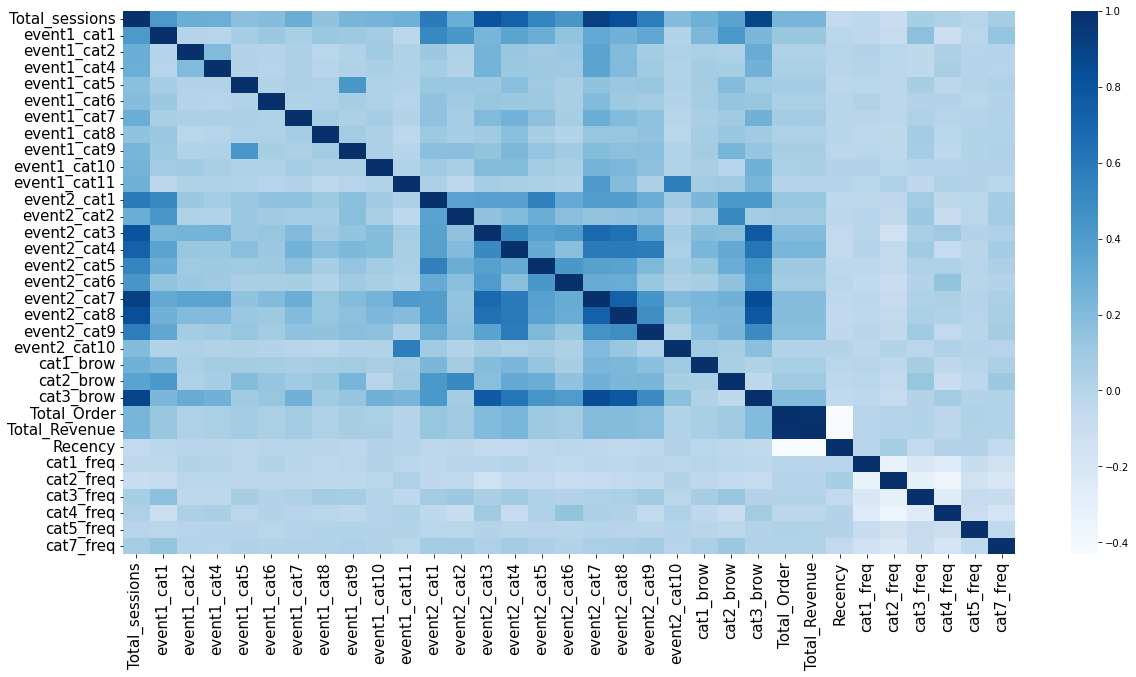

In [ ]:
corr = train_x.corr() 
plt.figure(figsize=(20, 10))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
           cmap="Blues",
           fmt='d')
plt.tick_params(labelsize = 15)
plt.show()

Since total sessions is highly correlated with several variables (cat3_brow, event2_cat9, evnet2_cat8, event2_cat5, event2_cat4, event2_cat3). I will drop the total sessions from my features.  The results features are time-related, purchased-related, product-related. The final features as following: 

#### Features Description: 
Non-Transactional Data:
- How the customer interacts with your website (online event1 and event2). Which channel attracts more customers?
 - Number of sessions for each category in event1 and event2 
   - event1_cat1 
   - event1_cat2 
   - event1_cat4 
   - event1_cat5 
   - event1_cat6 
   - event1_cat7 
   - event1_cat8 
   - event1_cat9 
   - event1_cat10
   - event1_cat11
   - event2_cat1 
   - event2_cat2 
   - event2_cat3 
   - event2_cat4 
   - event2_cat5 
   - event2_cat6 
   - event2_cat7 
   - event2_cat8 
   - event2_cat9 
   - event2_cat10

Transactional Data: 
- Total order number  
   - Total_Order : Total number of orders of each customer in the training phase.
- Order Regency 
   - Recency : Number of days since last purchased 
- Order Frequncy  : order frequency of each category in procast1 per customer in the training phase 
   - cat1_freq
   - cat2_freq
   - cat3_freq
   - cat4_freq
   - cat5_freq
   - cat7_freq
- Order Revenue 
   - Total_Revenue : total revenue of each customer in the training phase.

# 4.	Model Generation  

- Model Performance
  - Use Grid Serach Method to find the best parameters 
  - Evalute Results based on test sets using AUC
  
- Overfitting Problem : Using ensemble methods 
  - Bagging method: Random Forest (Multi-class Classfication)

## 4.1 Grid Search to find the best parameters 

In [ ]:
# Drop feature  
train_x =  train_x.drop(columns =['Total_sessions'])
test_x =  test_x.drop(columns =['Total_sessions'])

In [ ]:
rf = RandomForestClassifier()
param_grid = {
    'max_depth': list(range(5, 10)),
    'max_leaf_nodes': list(range(8, 12)),
    'max_features': ['sqrt', 'auto', 'log2'],
    'n_estimators':[100,200]}

rf_cv = GridSearchCV(estimator = rf,
                     param_grid = param_grid)
rf_cv.fit(train_x, train_y)
print(rf_cv.best_params_)

{'max_depth': 5, 'max_features': 'auto', 'max_leaf_nodes': 11, 'n_estimators': 200}


## 4.2 Random Forest Model Fitting 

In [ ]:
# Fit the model based on the GridSearch Result
rf = RandomForestClassifier(n_estimators=200, max_depth = 9, max_features = 'sqrt', max_leaf_nodes= 10).fit(train_x,train_y)
y_pred = rf.predict(test_x)

y_pred

array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 1., 1., 0., 1.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

## 4.3 Feature Importance Analysis 

Feature importance of Random Forest Model


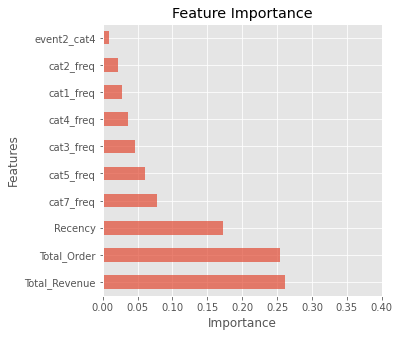

In [ ]:
# Check feature importance and display in bar plot.
print('Feature importance of Random Forest Model')
plt.style.use('ggplot')
fig = plt.figure(figsize=(5, 5))
feat_importances = pd.Series(rf.feature_importances_, index = test_x.columns)
feat_importances.nlargest(10).plot(kind='barh', alpha=0.7)
plt.xlim(left =0, right = 0.4)
plt.ylabel('Features')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

From the feature importance analysis, we can infer that the buying probability is depended on the total number of order, total revenue, recency and previous purchasing behavior of each customer. 

## 4.4 Prediction Analysis

In [ ]:
# export model
import joblib
joblib.dump(rf, 'rf_model.pkl')



# show results
#print('Accuracy of Random Forest Model: ', accuracy_score(test_y, y_pred))



['rf_model.pkl']

In [ ]:
results = rf.predict_proba(test_x) # return [n_samples, n_classes ]
df = pd.DataFrame({'custno': test.custno,
                   'procat1_1': list(results[0][:, 1]),
                   'procat1_2': list(results[1][:, 1]),
                   'procat1_3': list(results[2][:, 1]),
                   'procat1_4': list(results[3][:, 1]),
                   'procat1_5': list(results[4][:, 1]),
                   'procat1_7': list(results[5][:, 1])})
df.head()

,custno,procat1_1,procat1_2,procat1_3,procat1_4,procat1_5,procat1_7
0,8,0.310736,0.545641,0.483954,0.430366,0.112554,0.387074
1,11,0.369616,0.503367,0.650059,0.559022,0.174819,0.516744
2,13,0.008423,0.021247,0.016183,0.012972,0.004628,0.011047
3,17,0.168928,0.391481,0.325640,0.213848,0.054343,0.249675
4,19,0.009094,0.022791,0.018934,0.015340,0.005149,0.012952


Text(0, 0.5, 'Prediction of Purchasing Probability')

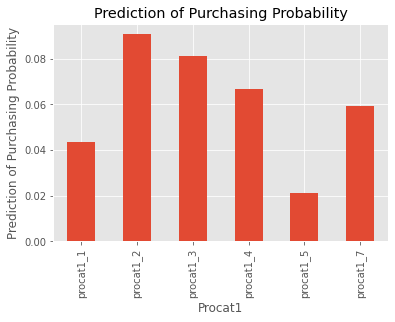

In [ ]:
df.drop(columns = ['custno']).mean().plot(kind= 'bar')
plt.title("Prediction of Purchasing Probability")
plt.xlabel('Procat1')
plt.ylabel('Prediction of Purchasing Probability')

The prediction results still show that most of the people will unlikely to make any purchase in the following half years. While among all the category, class 2 in procat1 is the most likely purchase category across all the customers.

# 5. Model Evaluation 

### Check Previous Buying Probability 

Text(0.5, 1.0, 'Buying Probability of each category in Procat1')

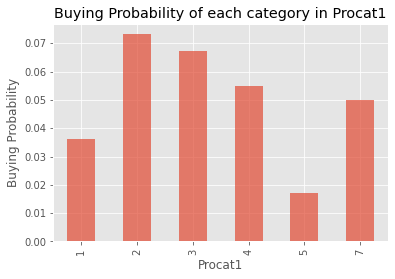

In [ ]:
train_y.mean().plot(kind='bar', alpha=0.7)
plt.xlabel('Procat1')
plt.ylabel('Buying Probability')
plt.title('Buying Probability of each category in Procat1')

Since most of people don't buy product dur the session time, so the dataset is highly imblanced. In this condition, the accuracy is not appropriate. I will use AUC score to evluate the model performance, which accounts for both true- positive and false-positive rates. 

## 5.1 Confusion Matrix  

In [ ]:
print(classification_report(test_y,y_pred)) 

              precision    recall  f1-score   support

           0       0.92      0.05      0.10      1130
           1       0.78      0.30      0.44      1122
           2       0.83      0.41      0.55       984
           3       0.69      0.20      0.31       743
           4       0.00      0.00      0.00       753
           5       0.84      0.24      0.38       916

   micro avg       0.80      0.21      0.33      5648
   macro avg       0.68      0.20      0.29      5648
weighted avg       0.71      0.21      0.30      5648
 samples avg       0.03      0.02      0.02      5648



## 5.2 AUC & ROC

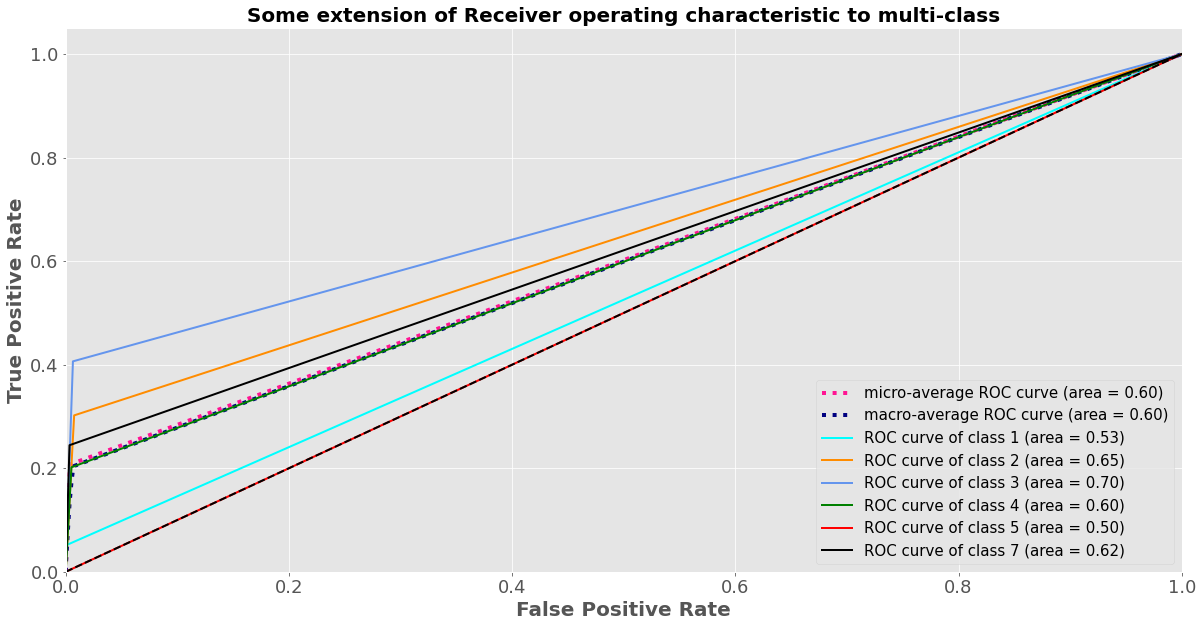

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = test_y.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_y.iloc[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(
    test_y.values.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(20, 10))
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label = 'micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color = 'deeppink', linestyle = ':', linewidth = 4)

plt.plot(fpr["macro"], tpr["macro"],
         label = 'macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color = 'navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue',
                'green', 'red'])
for i, color in zip(range(n_classes-1), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot(fpr[5], tpr[5],
         label = 'ROC curve of class 7 (area = {0:0.2f})'
               ''.format(roc_auc[5]),
         color = 'black', lw=lw)   

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20, weight = 'bold')
plt.ylabel('True Positive Rate', fontsize = 20, weight = 'bold')
plt.title('Some extension of Receiver operating characteristic to multi-class',
          fontsize = 20, weight = 'bold')
plt.legend(loc = "lower right", fontsize = 15)
plt.tick_params(labelsize = 18)
plt.savefig('auc.png')
plt.show()

When auc approach to 1, it means that we have a good model performance.  The micro/macro-average AUC of this model is around 0.60. The highest AUC score for class3 in procast1, which his around 0.71.

# 6. Summary

The customer segmentation analysis indicated that most of the customers are inactive and purchase little. There’s a huge difference between best customers and lost cheap customers in terms of recency, frequency, and revenue.  The company should use different strategies to market each group of customers. <br/>

- High Value: Improve Retention
- Mid Value: Improve Retention + Increase Frequency
- Low Value: Increase Frequency

The purchasing behavior is depended on the total number of order, total revenue, recency and previous purchasing behavior of each customer. The prediction results still show that most of the people will unlikely to make any purchase in the following half years. While among all the category, class 2 in procat1 is the most likely purchase category across all the customers.  Therefore, the marketing team still need to work on improving retention and frequency. 


The problem of the Data : 

The online data only include 3 class in online browsing category (procat1), while proact1 has a total of 6 classes. The online data is not complete, making the model less robust.
